In [20]:
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt, dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, Dropout
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

#### Read stock data and preprocess, obtain close price for all stocks

In [6]:
import pandas as pd
import numpy as np
import datetime as dt
data = pd.read_csv('..\\data\\test_2019to2020.csv', parse_dates=['Date'])
# # drop columns and maintain close price
# data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
# convert date to time datetime
data['Date'] = pd.to_datetime(data['Date'])

In [4]:
def company_data(company, start_time, end_time):
    """ extract specific column containing company name """
    column_list = ['Date']
    column_list.append(company)
    specific_data = data[column_list]
    return specific_data[(specific_data['Date'] > start_time) 
        & (specific_data['Date'] < end_time)]
def data_processing(data, seq_length):
    X_train, y_train = [], []
    for i in range(seq_length, len(data)):
        # X_train contain groups of #seq_length numbers
        X_train.append(data[i-seq_length:i, 0])
        # y_train contains the data right after X_train
        y_train.append(data[i, 0])
    return np.array(X_train), np.array(y_train)

In [7]:
company = 'AA'
start_time = dt.datetime(2019,7,7)
end_time = dt.datetime(2020,4,2)
company_stock_price = company_data(company, start_time, end_time)

#### Visualization of daily prices and 30-day moving average

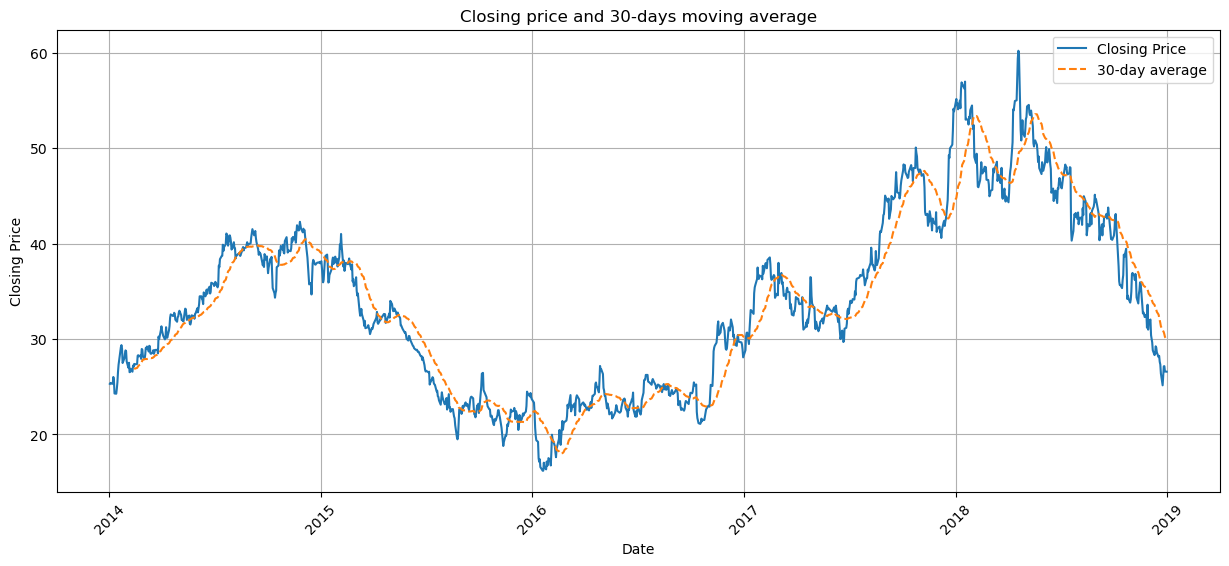

In [4]:
# visualization
window = 30 # moving average of 30 days
plt.figure(figsize=(15,6))
plt.plot(company_stock_price['Date'], company_stock_price[company], label='Closing Price')
plt.plot(company_stock_price['Date'], company_stock_price[company].rolling(window=window).mean(), 
        label=f'{window}-day average', linestyle='--')
plt.title(f'Closing price and {window}-days moving average')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid()
plt.legend()

#### Monthly Seasonality of Closing prices

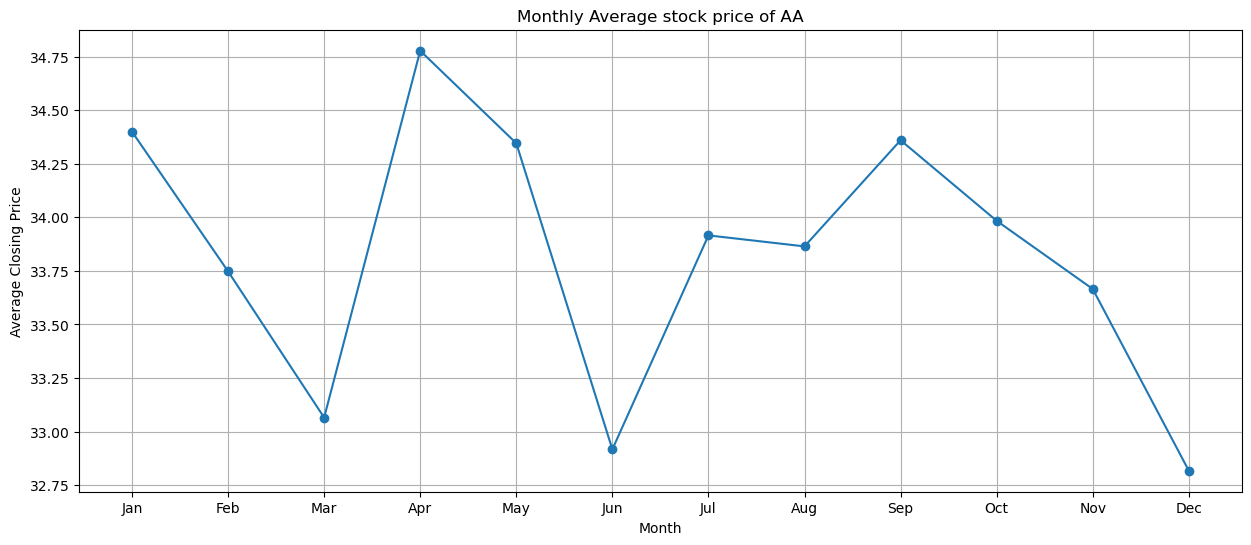

In [5]:
company_stock_price['Month'] = company_stock_price['Date'].dt.month
monthly_average = company_stock_price.groupby('Month')[company].mean()
plt.figure(figsize=(15,6))
plt.plot(monthly_average.index, monthly_average.values, marker='o')
plt.title(f'Monthly Average stock price of {company}')
plt.xlabel('Month')
plt.ylabel('Average Closing Price')
plt.xticks(range(1,13), 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid()

#### Data preprocessing for LSTM

In [ ]:
price = np.array(company_stock_price[company])
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(price.reshape(-1,1))
dev_size = 0.2
split = int(len(normalized_data) * (1-dev_size))
train_data, dev_data = normalized_data[:split], normalized_data[split:]
PAST_LENGTH = 60
X_train, y_train = data_processing(train_data, PAST_LENGTH)
X_test, y_test = data_processing(dev_data, PAST_LENGTH)
# reshape to tensor
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

#### LSTM model training

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.summary()

In [10]:
model.compile(loss='mean_squared_error', optimizer='Adam')

In [ ]:
checkpoints = ModelCheckpoint(filepath='weights\\LSTM_weights.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model.fit(X_train, y_train, 
        validation_data=(X_test, y_test), 
        epochs=100,
        batch_size=32,
        verbose=1,
        callbacks=[checkpoints, early_stopping])

In [8]:
model = load_model('..\\weights\\LSTM_AA_weights.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
____________________________________________________

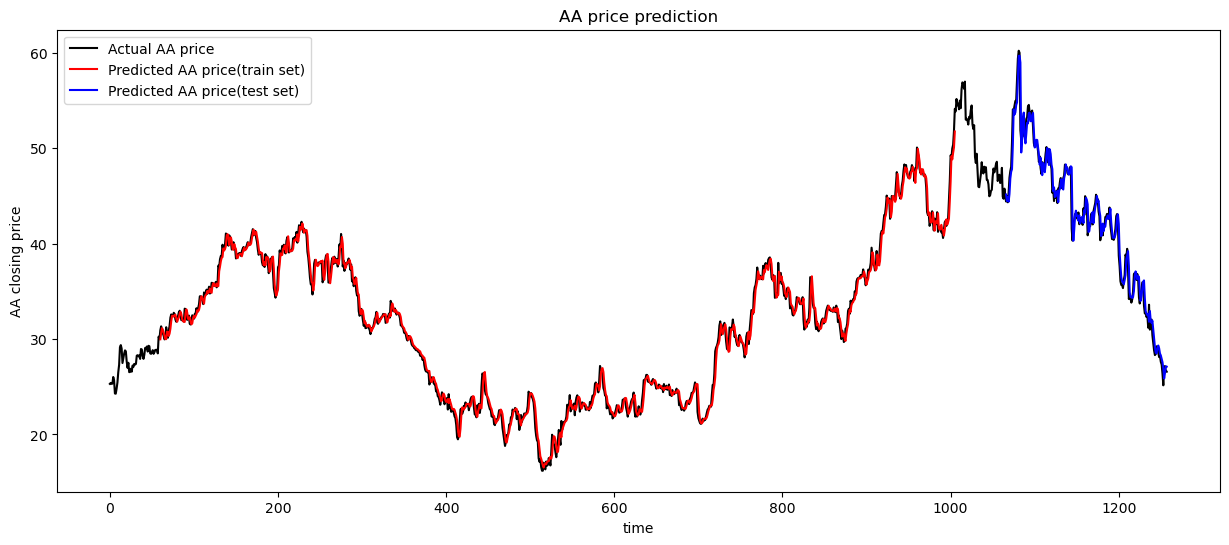

In [11]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
# undo normalization process
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
# Set the number of previous time steps to consider for plotting
look_back = PAST_LENGTH

# Initialize an array for plotting the train predictions
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:] = np.nan
# Assign the predicted values to the appropriate location for train predictions
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()
# Initialize an array for plotting the test predictions
testPredictPlot = np.empty_like(price)
testPredictPlot[:] = np.nan
# Calculate the starting index for the test predictions
test_start = len(price) - len(test_predict)
# Assign the predicted values to the appropriate location for test predictions
testPredictPlot[test_start:] = test_predict.flatten()

# Rescale the scaled data back to its original scale using the scaler
original_scaled_data = scaler.inverse_transform(normalized_data)

# Plotting the baseline data, training predictions, and test predictions
plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual {company} price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted {company} price(train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted {company} price(test set)")

plt.title(f"{company} price prediction")
plt.xlabel("time")
plt.ylabel(f"{company} closing price")
plt.legend()
plt.show()

#### Check predicted array

In [14]:
price = np.array(company_stock_price[company])
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(price.reshape(-1,1))
X_test, y_test = data_processing(normalized_data, PAST_LENGTH)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
test_predict = model.predict(X_test)

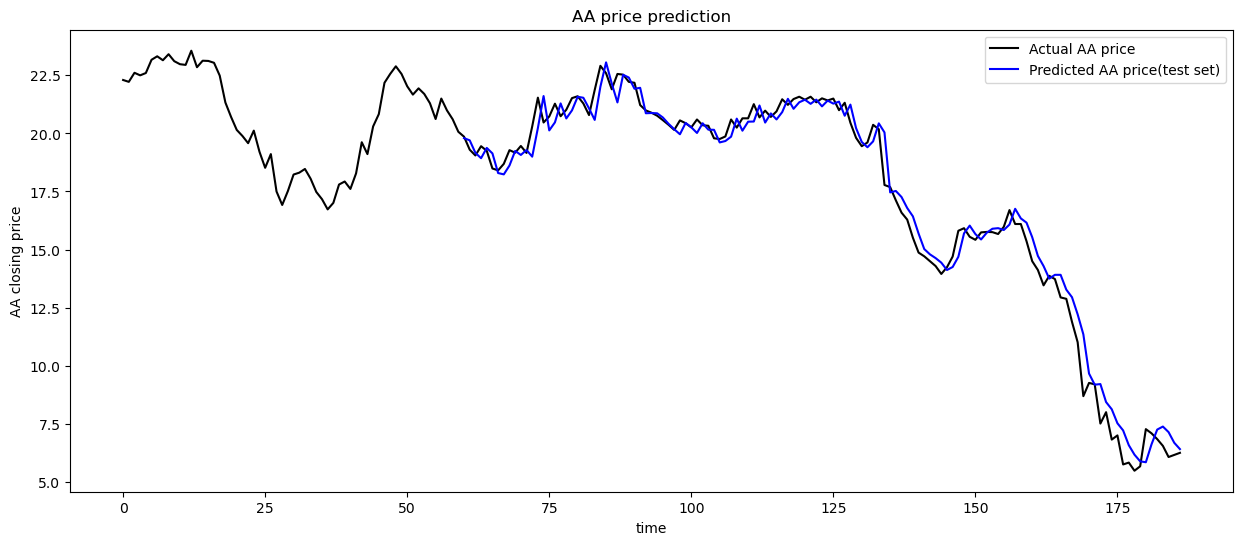

In [16]:
# undo normalization process
inverse_test_predict = scaler.inverse_transform(test_predict)
# Set the number of previous time steps to consider for plotting
look_back = PAST_LENGTH

testPredictPlot = np.empty_like(price)
testPredictPlot[:] = np.nan
testPredictPlot[look_back:len(test_predict)+look_back] = inverse_test_predict.flatten()

# Rescale the scaled data back to its original scale using the scaler
original_scaled_data = scaler.inverse_transform(normalized_data)

# Plotting the baseline data, training predictions, and test predictions
plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual {company} price")
plt.plot(testPredictPlot, color='blue', label=f"Predicted {company} price(test set)")

plt.title(f"{company} price prediction")
plt.xlabel("time")
plt.ylabel(f"{company} closing price")
plt.legend()
plt.show()

In [26]:
comparison_array = np.hstack((original_scaled_data[look_back:], inverse_test_predict))
analysis = pd.DataFrame(comparison_array, columns=['Original', 'Predicted'])
analysis

,Original,Predicted
0,19.860001,19.796329
1,19.299999,19.702696
2,19.049999,19.164474
3,19.450001,18.932993
4,19.250000,19.376329
...,...,...
122,6.840000,7.250823
123,6.550000,7.381437
124,6.070000,7.141448
125,6.160000,6.683272
